# Multi-Model Network
Having trained autoencoders our visual agent got some *senses* and *awarenesses*.
To make it all operational the agent still has a lot of work to do:
the agent needs to figure out the actual reasoning.

Reasoning is a teamwork, what we want for our agent:
the network of the models trainable *online in parallel*.

Here comes the next challenge: we add a conversation layer - the tags.
in addition to encoding and decoding the experiences
the agent learns to map the signal (tags) into its perception
with the goal to be able to answer tag-related queries.

In [1]:
tags = ['Sky','Horizon','Ground','?']
N_TAGS = len(tags)

# takes batch of coordinates, returns corresponding view tags
def get_tags(coords): 
    T = np.zeros((coords.shape[0], N_TAGS))
    sky = np.where(coords[:,1] < -30)[0]
    T[sky,0] = 1
    horizon = np.where((coords[:,1] >= -30) & (coords[:,1] < 30))[0]
    T[horizon,1] = 1
    ground = np.where(coords[:,1] >= 30)[0]
    T[ground,2] = 1
    return T

In [2]:
import gym
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import seaborn as sb
import matplotlib.pyplot as plt
from gym_unity.envs import UnityEnv
from local import train_online, plot_history, plot_predicted_vs_observed, run_seq
%matplotlib inline

Using TensorFlow backend.


In [3]:
# SimpleEnvironment scene opened in Unity editor
env_name = None # use Unity editor
env = UnityEnv(env_name, worker_id = 0, use_visual = True)

INFO:mlagents.envs:Start training by pressing the Play button in the Unity Editor.
INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: SimpleEnvironment
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: Turn HORIZONTAL, Tilt VERTICAL
INFO:gym_unity:1 agents within environment.


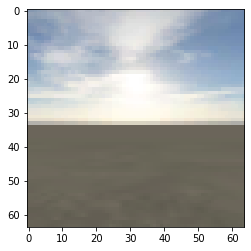

In [4]:
env.reset()
# get observation after taking action 0,0 (doing nothing)
observation, r, s, info = env.step([0.0, 0.0])

plt.imshow(observation)
plt.show()

In [5]:
IMG_DIM = observation.shape
ACT_DIM = (2,) # azimuth, altitude
N_CHANNELS = observation.shape[-1]
print('Image shape: {}  Channels: {}'.format(IMG_DIM, N_CHANNELS))

Image shape: (64, 64, 3)  Channels: 3


In [6]:
LATENT_DIM = 32

In [7]:
# agent's cortex structure
N_FILTERS = 32
N_LAYERS = 3

In [8]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, Dense, Flatten, Concatenate, Reshape
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU

### Team of models
We keep autoencoder model in.

In [9]:
# takes an observation + action pair and outputs `idea`
def encoder(img_dim, act_dim, latent_dim, name = 'encoder'):
    n, f, s = N_LAYERS, N_FILTERS, (3, 3)
    observation = Input(shape = img_dim, name = 'observation')
    action = Input(shape = act_dim, name = 'action')
    thought = observation
    for i in range(n):
        thought = Conv2D(f, s, activation = None, padding = 'same')(thought)
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
        thought = MaxPooling2D((2, 2), padding = 'same')(thought)
    thought = Flatten()(thought)
    thought = Concatenate()([thought, action])
    thought = Dense(latent_dim, activation = None, name = 'idea')(thought)
    idea = BatchNormalization()(thought)
    return Model([observation, action], idea, name = name)

In [10]:
# take `idea` and restore the image in the original format
def decoder(img_dim, latent_dim, name = 'decoder'):
    n, f, s = N_LAYERS - 1, N_FILTERS, (5, 5)
    d = img_dim[0]//np.power(2, n)
    idea = Input(shape = (latent_dim,), name = 'idea')
    thought = Dense(d * d * f, activation = 'relu')(idea)
    thought = Reshape((d, d, f))(thought)
    for i in range(n):
        thought = Conv2D(f, s, activation = None, padding = 'same')(thought)
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
        thought = UpSampling2D((2, 2))(thought)
    view = Conv2D(img_dim[-1], (3, 3), activation = 'sigmoid', padding = 'same', name = 'imagined')(thought)    
    return Model(idea, view, name = name)

We introduce more players, we put them in charge of conditional queries: if the present view is sky, or ground, or horizon, or none of that for example.

In [11]:
# take encoding and return a tag
def latent_discriminator(latent_dim, n_tags, name = 'latent_discriminator'):
    idea = Input(shape = (latent_dim,))
    thought = idea
    for i in range(N_LAYERS):
        thought = Dense(latent_dim, activation = None)(thought)
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
    tag = Dense(n_tags, activation = 'softmax')(thought)
    return Model(idea, tag, name = name)

In [12]:
# take a view and return a tag
def visual_discriminator(img_dim, n_tags, name = 'visual_discriminator'):
    n, f, s = N_LAYERS, N_FILTERS, (3, 3)
    view = Input(shape = img_dim, name = 'view')
    thought = view
    for i in range(n):
        thought = Conv2D(f, s, activation = None, padding = 'same')(thought)
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
        thought = MaxPooling2D((2, 2), padding = 'same')(thought)
    thought = Flatten()(thought)
    tag = Dense(n_tags, activation = 'softmax', name = 'visual_tag')(thought)
    return Model(view, tag, name = name)

In [13]:
# takes a tag and return encoding
def mapper(latent_dim, n_tags, name = 'tag_mapper'):
    tag = Input(shape = (n_tags,))
    thought = tag
    for i in range(N_LAYERS):
        thought = Dense(latent_dim, activation = None)(thought)
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
    thought = Dense(latent_dim, activation = None)(thought)
    idea = BatchNormalization()(thought)
    return Model(tag, idea, name = name)

Now we can put the team together.

In [14]:
def build(img_dim, act_dim, latent_dim, n_tags):
    # encoder
    encode = encoder(img_dim, act_dim, latent_dim)
    encode.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # decoder
    decode = decoder(img_dim, latent_dim)
    decode.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # encoding discriminator
    ld = latent_discriminator(latent_dim, n_tags)
    ld.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    # visual discriminator
    vd = visual_discriminator(img_dim, n_tags)
    vd.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    # tag mapper
    tm = mapper(latent_dim, n_tags)
    tm.compile(optimizer = 'adam', loss = 'mean_squared_error')    
    # inputs
    observation = Input(shape = img_dim, name = 'observation')
    action = Input(shape = act_dim, name = 'action')
    tag = Input(shape = (n_tags,), name = 'tag')
    # team-network
    idea = encode([observation, action])
    vision = decode(idea)
    perception = vd(observation)
    judgement = vd(vision)
    distinction =ld(idea)
    imagination = decode(tm(tag))
    mind = Model([observation, action, tag], [vision, perception, judgement, distinction, imagination])
    return encode, decode, ld, vd, tm, mind

In [15]:
# instantiate all
encode, decode, ld, vd, tm, model = build(IMG_DIM, ACT_DIM, LATENT_DIM, N_TAGS)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
action (InputLayer)             (None, 2)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 32)           85536       observation[0][0]                
                                                                 action[0][0]                     
__________________________________________________________________________________________________
tag (InputLayer)                (None, 4)            0                                            
__________

In [16]:
# take colected batch and return required inputs and targets
def make_batch(V, A, X):
    # we've got V: observations resulted from actions A
    # we need observations A was initiated from
    # discard first pair and instead append pair:
    # zero-action (no move) and repeat last observation
    A1 = np.vstack((A[1:,:], np.zeros((1, 2))))
    V1 = np.vstack((V[1:,:], V[-1:,:]))
    # categories for observations
    L = get_tags(np.vstack((X[1:,:], X[-1:,:])))
    return [V, A1, L], [V1, L, L, L, V]

Setting lower weight makes corresponding objective to be trained in the later stages
when the high-weight objectives are already settled down. The most important here is *visual comprehension*.
(Scale depends on the loss function used.)

In [17]:
# loss calc for all network outputs
loss_func = ['mean_squared_error'] + ['binary_crossentropy'] * 3 + ['mean_squared_error']
loss_weights = [1] + [1e-3] * 3 + [5e-2]

# compile with `loss` and `weight`
model.compile(optimizer = 'adam', loss = loss_func, loss_weights = loss_weights)

      1 Loss  trainig: 0.0445 validation: 0.0815
     10 Loss  trainig: 0.0061 validation: 0.0246
     20 Loss  trainig: 0.0058 validation: 0.0074
     30 Loss  trainig: 0.0048 validation: 0.0051
     40 Loss  trainig: 0.0046 validation: 0.0054
     50 Loss  trainig: 0.0038 validation: 0.0042
     60 Loss  trainig: 0.0038 validation: 0.0042
     70 Loss  trainig: 0.0031 validation: 0.0038
     80 Loss  trainig: 0.0030 validation: 0.0037
     90 Loss  trainig: 0.0030 validation: 0.0038
    100 Loss  trainig: 0.0025 validation: 0.0035


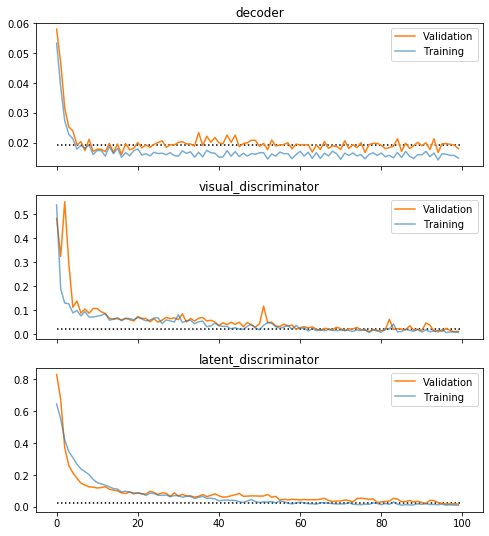

In [18]:
# train model and plot training loss
log, V, A, X = train_online(env, model, make_batch)
plot_history(log) 

In [19]:
# get labels for the last training batch
L = get_tags(np.vstack((X[1:,:], X[-1:,:])))
# last training batch results
vision, perception, judgement, distinction, imagination = model.predict([V, A, L])

In [20]:
# show label and score assigned to a view
def plot_discriminator_value(views, labels):
    k = len(views)
    fig, ax = plt.subplots(1, k, figsize = (15, 2))
    for i in range(k):
        j = np.argmax(labels[i,:])
        ax[i].set_title(tags[j] if labels[i,j] > .1 else '?')
        ax[i].set_xlabel('{:.4f}'.format(labels[i,j]))
        ax[i].imshow(views[i,:])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()


Visual discriminator on real observations: 4.30% error


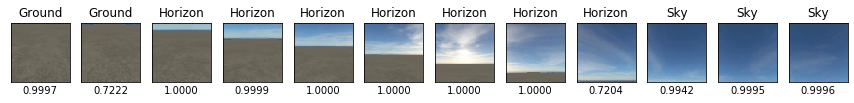

Visual discriminator on `imagination`: 0.39% error


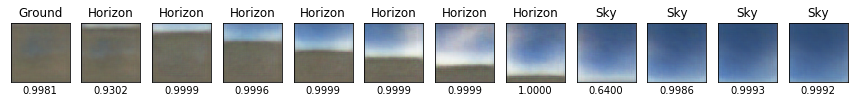

`Mental` discriminator on `ideas`: 0.78% error


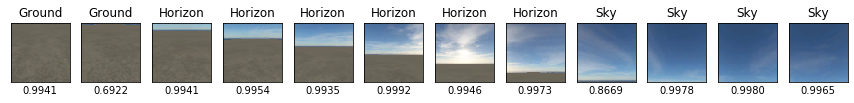

Visual `concept` from tag:


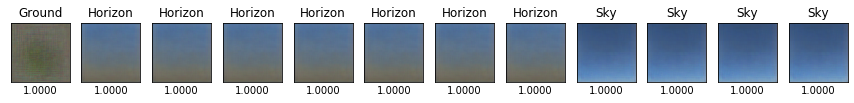

In [21]:
correct = (np.argmax(L, axis = 1))
norm = 100 / correct.shape[0] 

print('\nVisual discriminator on real observations: {:.2f}% error'\
          .format((correct != np.argmax(perception, axis = 1)).sum() * norm))
plot_discriminator_value(V[55:90:3,:], perception[55:90:3,:])
print('Visual discriminator on `imagination`: {:.2f}% error'\
          .format((correct != np.argmax(judgement, axis = 1)).sum() * norm))
plot_discriminator_value(vision[55:90:3,:], judgement[55:90:3,:])
print('`Mental` discriminator on `ideas`: {:.2f}% error'\
          .format((correct != np.argmax(distinction, axis = 1)).sum() * norm))
plot_discriminator_value(V[55:90:3,:], distinction[55:90:3,:])
print('Visual `concept` from tag:')
plot_discriminator_value(imagination[55:90:3,:], L[55:90:3,:])

In [22]:
env .close()

In [23]:
# save model
encode.save_weights('env-encode.h5')
decode.save_weights('env-decode.h5')
ld.save_weights('env-LD.h5')
vd.save_weights('env-VD.h5')
tm.save_weights('env-mapper.h5')